## 5 Results and investment strategies on real data
### 5.3 Strategies study

In [1]:
import os
path = os.getcwd() + '/results/'
path_data = os.getcwd() + '/data/'

os.chdir('../')
from inference_mahmm import *

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

palette = sns.color_palette("tab10", 10)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


##### Results recuperation

In [2]:
valeur = 'sp500'
y, dates = np.load(path + f'y_{valeur}_L0_monthly_bis.npy'), np.load(path + f'dates_{valeur}_L0_monthly_bis.npy')
dates = [pd.to_datetime(d) for d in dates]

xb_L0, xc_L0 = np.load(path + f'xb_{valeur}_L0_monthly_bis.npy'), np.load(path + f'xc_{valeur}_L0_monthly_bis.npy')
xb_L2, xc_L2 = np.load(path + f'xb_{valeur}_L2_monthly_bis.npy'), np.load(path + f'xc_{valeur}_L2_monthly_bis.npy')
xb_L5, xc_L5 = np.load(path + f'xb_{valeur}_L5_monthly_bis.npy'), np.load(path + f'xc_{valeur}_L5_monthly_bis.npy')
xb_L8, xc_L8 = np.load(path + f'xb_{valeur}_L8_monthly_bis.npy'), np.load(path + f'xc_{valeur}_L8_monthly_bis.npy')
xb_L10, xc_L10 = np.load(path + f'xb_{valeur}_L10_monthly_bis.npy'), np.load(path + f'xc_{valeur}_L10_monthly_bis.npy')
xb_Lvar, xc_Lvar = np.load(path + f'xb_{valeur}_Lvar_monthly.npy'), np.load(path + f'xc_{valeur}_Lvar_monthly.npy')

In [3]:
valeur_cash, code_cash = 'TBIL', 'TBIL'
DATA_cash = data(code_cash, '01/01/2000', dates[0], 0, path_data + 'data_sp500.csv')
y_cash = DATA_cash.log_ret_oos

In [4]:
df = pd.DataFrame({'date':dates,
                   'y': y,
                   'xb_L0':xb_L0,
                   'xc_L0':xc_L0,
                   'xb_L2':xb_L2,
                   'xc_L2':xc_L2,
                   'xb_L5':xb_L5,
                   'xc_L5':xc_L5,
                   'xb_L8':xb_L8,
                   'xc_L8':xc_L8,
                   'xb_L10':xb_L10,
                   'xc_L10':xc_L10,
                   'xb_Lvar':xb_Lvar,
                   'xc_Lvar':xc_Lvar}).set_index('date', drop=True)
df_y_cash = pd.DataFrame({'date':DATA_cash.date_oos,
                          'y': DATA_cash.log_ret_oos}).set_index('date', drop=True)
df['y_cash'] = df_y_cash.reindex(df.index).values/100
df = df.dropna()

dates, y, y_cash = list(df.index), np.array(df['y']), np.array(df['y_cash'])
xb_L0, xc_L0 = np.array(df['xb_L0']), np.array(df['xc_L0'])
xb_L2, xc_L2 = np.array(df['xb_L2']), np.array(df['xc_L2'])
xb_L5, xc_L5 = np.array(df['xb_L5']), np.array(df['xc_L5'])
xb_L8, xc_L8 = np.array(df['xb_L8']), np.array(df['xc_L8'])
xb_L10, xc_L10 = np.array(df['xb_L10']), np.array(df['xc_L10'])
xb_Lvar, xc_Lvar = np.array(df['xb_Lvar']), np.array(df['xc_Lvar'])

In [5]:
xb_all, xc_all = [np.ones(len(xb_L0)), xb_L0, xb_L2, xb_L5, xb_L8, xb_L10, xb_Lvar], [np.ones(len(xc_L0)), xc_L0, xc_L2, xc_L5, xc_L8, xc_L10, xc_Lvar]
signal_all = ['Benchmark', 'HMM', 'MA(2)-HMM', 'MA(5)-HMM', 'MA(8)-HMM', 'MA(10)-HMM', 'MA(L)-HMM with model selection']

##### Momentum strategy

In [6]:
returns = pd.Series(y)
lookback = 250
momentum_signal = returns.rolling(lookback).sum()
momentum_signal = (momentum_signal > 0).astype(int)

##### Maximum Drawdown

In [7]:
def max_drawdown(prices):
    cumulative_max = prices.cummax()
    drawdowns = (prices - cumulative_max) / cumulative_max
    return drawdowns.min()  

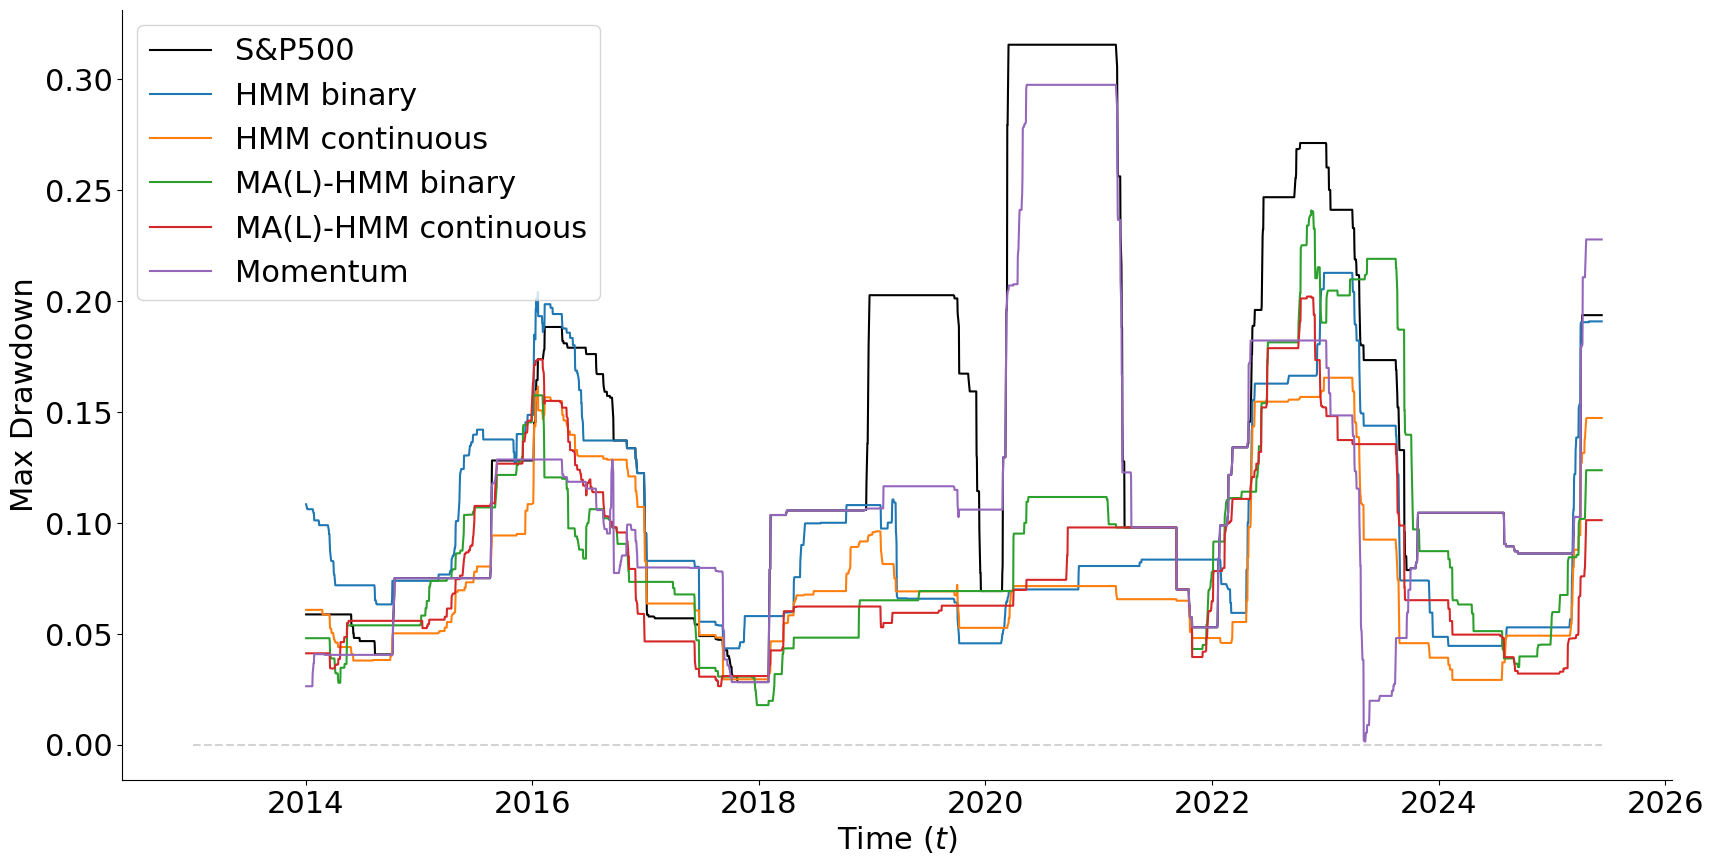

In [8]:
window = 250

fig, ax = plt.subplots(figsize=(20, 10))
plt.hlines(0, dates[0], dates[-1], linestyles='--', color='lightgrey')

strat_names = ['HMM binary', 'HMM continuous', 'MA(L)-HMM binary', 'MA(L)-HMM continuous', 'Momentum']
signals_all = [xb_L0, xc_L0, xb_Lvar, xc_Lvar, momentum_signal]

strat = pd.DataFrame(get_strat(x=np.ones(len(xb_L0)), fees=0.002, risky=y, riskfree=y_cash, nominal=100, type_strat='average')[1])
cum_strat = (1 + strat).cumprod()
rolling_mdd = np.abs(cum_strat.rolling(window=window).apply(max_drawdown, raw=False).dropna())
plt.plot(dates[(window-1):], rolling_mdd, label='S&P500', color='black')

for xi, x in enumerate(signals_all):
    strat = pd.DataFrame(get_strat(x=x, fees=0.002, risky=y, riskfree=y_cash, nominal=100, type_strat='average')[1])
    cum_strat = (1 + strat).cumprod()
    rolling_mdd = np.abs(cum_strat.rolling(window=window).apply(max_drawdown, raw=False).dropna())
    plt.plot(dates[(window-1):], rolling_mdd, label=strat_names[xi])

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Time ($t$)', fontsize=22)
plt.ylabel('Max Drawdown', fontsize=22)
plt.legend(fontsize=22)
sns.despine()
plt.show()